In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import requests

import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [2]:
# Import data
download_url('https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv', 'insurance.csv')
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [49]:
dataset.join(pd.get_dummies(dataset['sex']).pop('male')).drop('sex', axis='columns')

,age,bmi,children,smoker,region,expenses,male
0,54,27.6,1,no,northwest,11305.93,0
1,35,34.1,3,yes,northwest,39983.43,0
2,46,42.4,3,yes,southeast,46151.12,1
3,48,36.7,1,no,northwest,28468.92,1
4,18,30.1,0,no,northeast,21344.85,0
...,...,...,...,...,...,...,...
1333,37,27.7,3,no,northwest,7281.51,0
1334,58,27.2,0,no,northwest,12222.90,0
1335,25,34.0,1,no,southeast,3227.12,0
1336,18,33.5,0,yes,northeast,34617.84,1


In [56]:
# get cat vars

df = dataset.join(pd.get_dummies(dataset['sex']).pop('male')).drop('sex',  axis='columns')
df = df.join(pd.get_dummies(dataset['smoker']).pop('yes')).drop('smoker',  axis='columns').rename({'yes': 'smoker'}, axis=1)
df = df.join(pd.get_dummies(dataset['region'])).drop(['northeast', 'region'], axis='columns')

In [60]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2)
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')


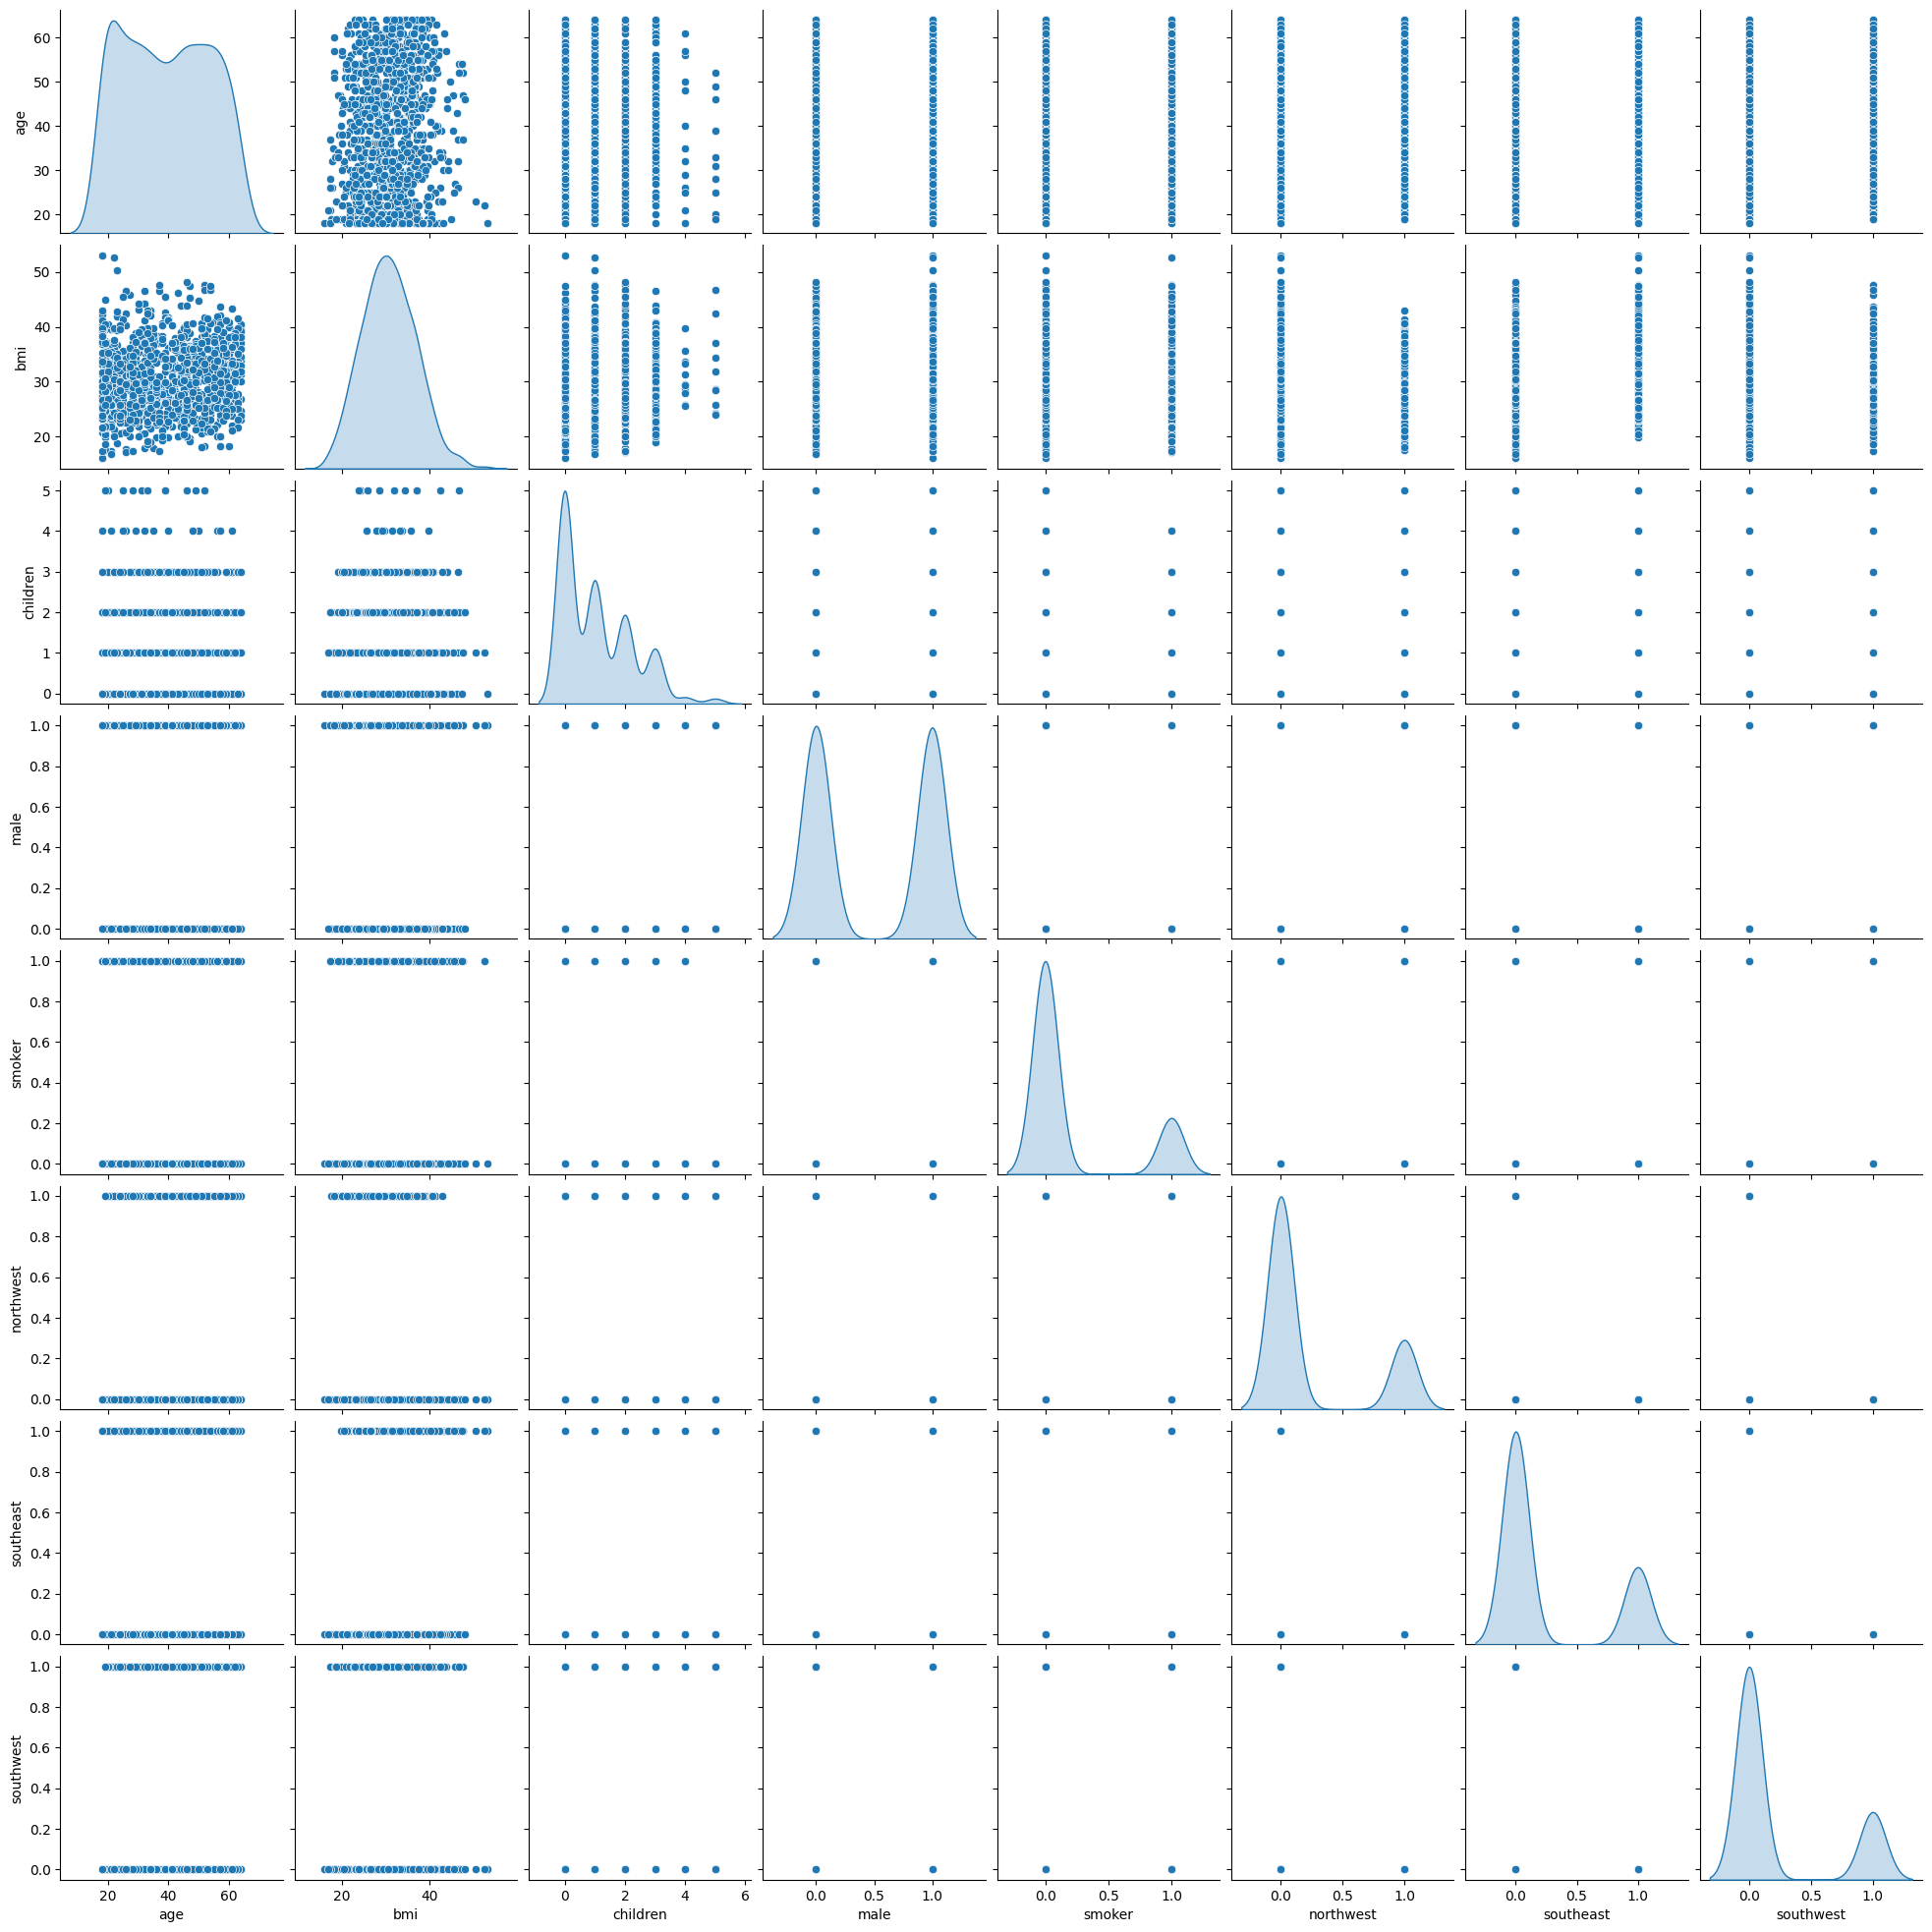

In [61]:
sns.pairplot(train_dataset, diag_kind="kde")


In [62]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [63]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [65]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 4s 4s/step


array([[-3.719051 ],
       [-2.0698414],
       [-3.0986292],
       [-2.1734858],
       [-3.2119074],
       [-1.2503994],
       [-3.400652 ],
       [-2.98381  ],
       [-2.5494838],
       [-2.4207563]], dtype=float32)

In [73]:
from tqdm import tqdm

In [74]:
EPOCHS = 1000
PBAR = tqdm(range(0, EPOCHS))


class UpdatePBar(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        PBAR.update(1)


history = model.fit(
    train_dataset,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[UpdatePBar()]
)


100%|██████████| 1000/1000 [02:01<00:00,  8.84it/s]

9/9 - 0s - loss: 25730632.0000 - mae: 2890.7058 - mse: 25730632.0000 - 67ms/epoch - 7ms/step
Testing set Mean Abs Error: 2890.71 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 1ms/step


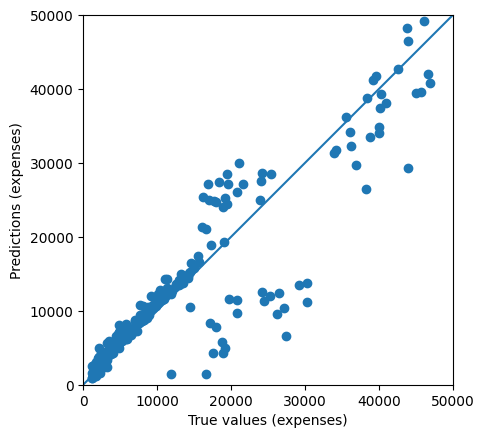

In [75]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
